In [1]:
from utils import adult_config, utils, GAE_trainer, analyze_utils, GAES_trainer, AAE_trainer
from models import GAE
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch

Early stopping at 5-th iteration


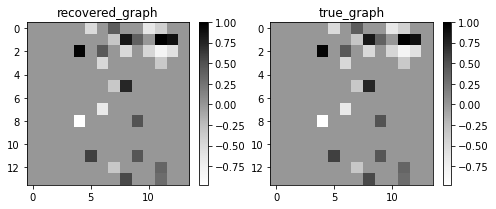

In [2]:
parser = adult_config.get_args()
args = parser.parse_args('')
options = vars(args)

# Reproducibility
utils.set_seed(options['seed'])

# Get dataset
df_train, df_test = utils.adult_preprocessing(n_train=options['n_train'], n_test=options['n_test'])
gae = GAE.GAE(len(df_train), options['d'], options['x_dim'], options['seed'], options['num_encoder_layers'],
              options['num_decoder_layers'],
              options['hidden_size'], options['latent_dim'], options['l1_graph_penalty'], options['learning_rate'],
              options['device'], options['n_feature'])

gae_trainer = GAE_trainer.GAETrainner(options['init_rho'], options['rho_thres'], options['h_thres'],
                                      options['rho_multiply'],
                                      options['init_iter'], options['learning_rate'], options['h_tol'],
                                      options['early_stopping'], options['early_stopping_thres'])
W_est = gae_trainer.train(gae, df_train.iloc[:, :-1].values.reshape(-1, options['d'], 1).astype(np.float32), None,
                          options['graph_thres'],
                          options['max_iter'], options['iter_step'])
W_est[:, 0] = 0.0

W_est_old = W_est.copy()
W_est = W_est / np.max(np.abs(W_est))  # Normalize
W_est[np.abs(W_est) < options['graph_thres']] = 0  # Thresholding

analyze_utils.plot_recovered_graph(W_est, W_est,
                                   save_name='output/thresholded_recovered_graph.png')


In [3]:
utils.set_seed(options['seed'])
print('Start training GAES')
gaes = GAES_trainer.GAESTrainner(gae.net.encoder, df_train.iloc[:, :-1].values.reshape(-1, options['d'], options['x_dim']).astype(np.float32), W_est_old,
                    max_epoch=200, n=len(df_train), d=options['d'], device=options['device'], weight_decay=0)
gaes.train()
test_do = gaes.net.get_result(torch.Tensor(df_test.iloc[:, :-1].values.astype(np.float32).reshape(len(df_test), -1, 1)).to(options['device']),
                               do=1).detach().cpu().numpy().reshape(len(df_test), -1)[:,1:]

Start training GAES
0.3000000000000001
Initial loss: 4.943355083465576
Final loss: 2.5228569507598877


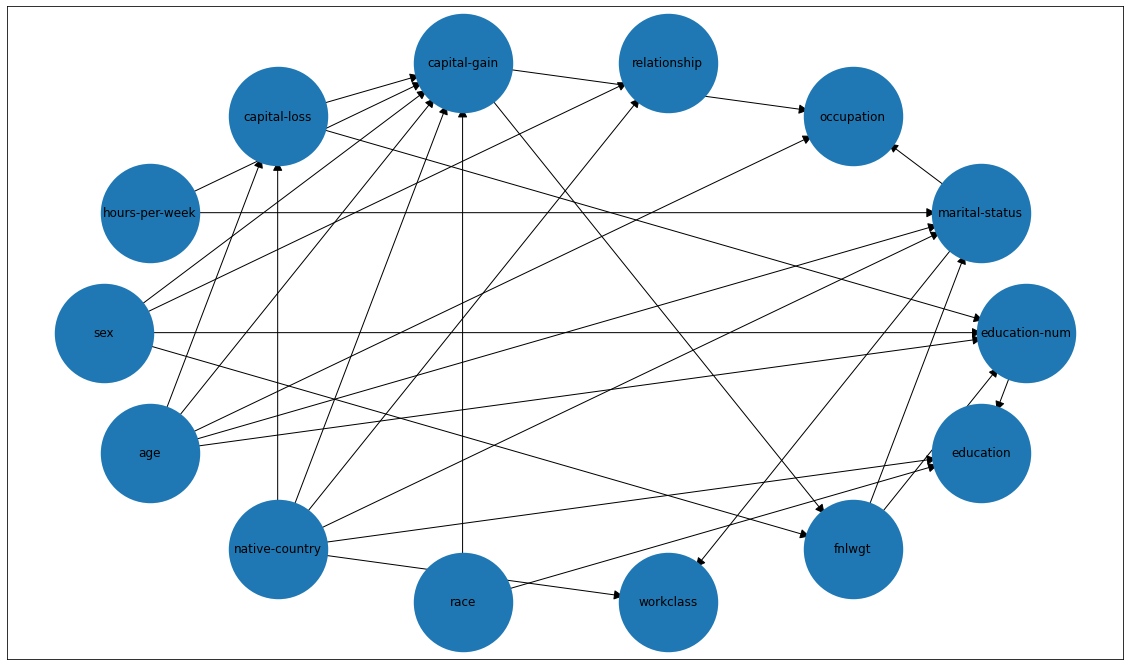

In [31]:
import matplotlib.pyplot as plt
import networkx as nx
W_est = W_est_old.copy()
W_est = W_est / np.max(np.abs(W_est))  # Normalize
W_est[np.abs(W_est) < 0.30] = 0  # Thresholding
G = nx.DiGraph(W_est)
nodesdic={0:'sex',1:'age',2:'native-country',3:'race',4:'workclass',5:'fnlwgt',6:'education', 7:'education-num',8:'marital-status',
          9:'occupation',10:'relationship',11:'capital-gain',12:'capital-loss',13:'hours-per-week'}

plt.figure(figsize=(20,12))
nx.draw_networkx(G, cmap = plt.get_cmap('jet'), labels=nodesdic, node_size=8000, pos=nx.shell_layout(G), arrowsize=20,  node_shape='o', linewidths=10)
# plt.show()
plt.savefig('adult_graph.png', dpi=300, bbox_inches='tight', pad_inches=0.01)

In [7]:
utils.set_seed(options['seed'])
print('Start pretrain AAE')
scaler = StandardScaler()
train_iter, eval_iter, scaler = utils.pretrain_split(df_train.iloc[:int(0.9*len(df_train))], df_train.iloc[int(0.9*len(df_train)):], scaler, 1)
aae_trainer = AAE_trainer.AAETrainer(options['d']-1, options['aae_hidden_dim'], options['aae_pretrain_epochs'], quantile=options['quantile'], device=options['device'], alpha=options['aae_alpha'], beta=options['aae_beta'])
aae_trainer._train(train_iter, eval_iter, pretrain=1)
print('Pre-training results')
df_org = utils.get_pretrain_results_adult(aae_trainer, df_test, test_do)
print('Start retrain AAE')
train_iter, eval_iter = utils.retrain_split(gaes, df_train.iloc[:int(0.9*len(df_train))], df_train.iloc[int(0.9*len(df_train)):], scaler, device=options['device'], adult=1)
aae_trainer.epochs = options['aae_retrain_epochs']
aae_trainer._train(train_iter, eval_iter, pretrain=0, ae_lr=options['ae_retrain_lr'], disc_lr=options['discriminator_retrain_lr'])
df_ad = utils.get_retrain_results_adult(aae_trainer, df_test, test_do)
utils.get_fairness_result(df_org, df_ad, cf=0)
print('done')

Start pretrain AAE
Pre-training results
Final Evalution loss for 0.20819176733493805
------------------------------------------------------------
Original
              precision    recall  f1-score   support

           0    0.85795   0.93517   0.89490     12000
           1    0.41061   0.22583   0.29140      2400

    accuracy                        0.81694     14400
   macro avg    0.63428   0.58050   0.59315     14400
weighted avg    0.78339   0.81694   0.79431     14400

[[11222   778]
 [ 1858   542]]
AUC-PR: 0.3269085569536998
AUC-ROC: 0.6546210590277777
Final Evalution loss for 0.5757627487182617
------------------------------------------------------------
Generated CF
              precision    recall  f1-score   support

           0    0.89899   0.03708   0.07123     12000
           1    0.16900   0.97917   0.28826      2400

    accuracy                        0.19410     14400
   macro avg    0.53400   0.50812   0.17974     14400
weighted avg    0.77733   0.19410   0.1074